In [1]:
# This notebook makes setolabo samples as test samples. 
# FD (Full datasets)
# Lung + colorectal + Gastric + Breast + brain + ovarian + prostate + carcinoma, all cancer type individually. 
# Also analysis of these cancer type 
# new gastric dataset for FD 4 (and onwards) now has 4 cancer types. FD3 doesn't have these many types for gastric, it has only 1 cancer type. 
# New prostate datasset is used for FD 5 and on onrwards
# New pancratic dataset is introduced for FD6 and onwards
# introducing new ovarian cancer dataset and also utilizing meta deta of it. 
#further using only 2 labels for ovarian dataset. (caccer and non  cancerous)
#in this notebook, i will introduce new method which is considering all the miRNA instead of only common

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# Define a function to calculate median of the 6 closest non-NaN values
def fill_with_closest_median_or_zero(column):
    # Create a copy of the column to avoid modifying in place
    filled_column = column.copy()
    for idx in column[column.isna()].index:  # Find indices of NaN values
        # Get the 3 previous and 3 next valid (non-NaN) values
        window = column[max(0, idx - 3): idx + 4].dropna()
        if len(window) > 0:
            # Compute the median of up to 6 closest values
            filled_column[idx] = window.median()
        else:
            # Fill with 0 if no valid values are found
            filled_column[idx] = 0
    return filled_column

In [4]:
path = 'E:/MedBank/head_model/NGS/data_shared_by_Takeshi-san/'
df_lung = pd.read_excel(path+'Lung/Lung cancer_miRNA exprission count data.xlsx')
# df_colo = pd.read_csv(path+'Colorectal/Colorectal_SRP411850_PRJNA909776.csv')
df_colo = pd.read_excel(path+'Colorectal/Colorectal cancer_miRNA expression count data.xlsx')
# df_gast = pd.read_excel(path+'gastric/PRJNA946800.xlsx')
df_gast = pd.read_excel(path+'gastric/Gastric cancer_miRNA expression count data.xlsx')
# df_breast = pd.read_csv(path+'breast/Breast_PRJNA934049_forR_edit.csv')
# df_breast = pd.read_excel(path+'breast/Breast_cancr_new expression count.xlsx')
df_breast = pd.read_csv(path+'kagawa/kagawa2.csv')
df_seto = pd.read_csv('E:/MedBank/head_model/NGS/data_shared_by_Takeshi-san/expression_count_test_20240807.csv')
# --> new
# df_brain = pd.read_excel(path+'brain/Brain tumor_Blood.xlsx')
df_brain = pd.read_excel(path+'brain/Brain tumor_miRNA expression count data.xlsx')
# df_ovarian = pd.read_excel(path+'ovarian/Ovarian_miRNA expression count data.xlsx')
df_ovarian = pd.read_excel(path+'ovarian/Ovarian2 Cancer_miRNA expression count data.xlsx')
# df_prostate = pd.read_excel(path+'prostate/Prostate_miRNA expression count data.xlsx')
df_prostate = pd.read_excel(path+'prostate/Prostate2.xlsx')
df_carcinoma = pd.read_excel(path+'Carcinoma/Squamous Cell Carcinoma_miRNA count data.xlsx')
df_pancreatic = pd.read_excel(path+'pancreatic/Pancreatic cancer_miRNA expression count data.xlsx')


# common_miRNA = set(df_colo['miRNA']) & set(df_gast['miRNA']) & set(df_breast['miRNA']) & set(df_brain['miRNA']) & set(df_ovarian['miRNA']) & set(df_prostate['miRNA']) & set(df_seto['gene_id'])  & set(df_lung['miRNA'])  & set(df_carcinoma['miRNA']) & set(df_pancreatic['miRNA'])

# Create a master feature list that includes all miRNA from all datasets
master_miRNA = set(df_colo['miRNA']) | set(df_gast['miRNA']) | set(df_breast['miRNA']) | \
               set(df_brain['miRNA']) | set(df_ovarian['miRNA']) | set(df_prostate['miRNA']) | \
               set(df_seto['gene_id']) | set(df_lung['miRNA']) | set(df_carcinoma['miRNA']) | \
               set(df_pancreatic['miRNA'])

# Convert the set to a list if needed
master_miRNA_list = list(master_miRNA)



# Ensure all features in master_miRNA are present in each dataset
def align_features(df, feature_col, master_features):
    # Create a DataFrame for missing features with all values as 0
    missing_features = master_features - set(df[feature_col])
    missing_df = pd.DataFrame({feature_col: list(missing_features)})
    
    # Add the missing features with all values set to 0
    for col in df.columns:
        if col != feature_col:
            missing_df[col] = 0

    # Combine original DataFrame with the missing features DataFrame
    aligned_df = pd.concat([df, missing_df], ignore_index=True)
    
    # Sort the combined DataFrame by the feature column
    return aligned_df.sort_values(by=feature_col).reset_index(drop=True)

# Apply to all datasets
df_lung = align_features(df_lung, 'miRNA', master_miRNA)
df_colo = align_features(df_colo, 'miRNA', master_miRNA)
df_gast = align_features(df_gast, 'miRNA', master_miRNA)
df_breast = align_features(df_breast, 'miRNA', master_miRNA)
df_brain = align_features(df_brain, 'miRNA', master_miRNA)
df_ovarian = align_features(df_ovarian, 'miRNA', master_miRNA)
df_prostate = align_features(df_prostate, 'miRNA', master_miRNA)
df_carcinoma = align_features(df_carcinoma, 'miRNA', master_miRNA)
df_pancreatic = align_features(df_pancreatic, 'miRNA', master_miRNA)

# For df_seto, adjust for 'gene_id'
df_seto = align_features(df_seto, 'gene_id', master_miRNA)




df_ovarian_meta = pd.read_csv(path+'ovarian/Ovarian cacner_metadata.csv')
labels_ovarian = []
diagnosis_to_label = {
    'Cancer': 5,
    'Control': 20
}
valid_columns = df_ovarian_meta['Run'].values
df_ovarian_filtered = df_ovarian.loc[:, (df_ovarian.columns[0] == df_ovarian.columns) | df_ovarian.columns.isin(valid_columns)]

# Iterate through the filtered columns (excluding the first column)
for col in df_ovarian_filtered.columns[1:]:
    diagnosis = df_ovarian_meta.loc[df_ovarian_meta['Run'] == col, 'diagnosis'].values[0]

    if diagnosis.startswith('Cancer'):
        labels_ovarian.append(diagnosis_to_label['Cancer'])
    elif diagnosis.startswith('Control'):
        labels_ovarian.append(diagnosis_to_label['Control'])
    else:
        # Drop columns with other diagnoses
        df_ovarian_filtered = df_ovarian_filtered.drop(columns=[col])
df_ovarian = df_ovarian_filtered




# Combine all datasets column-wise while avoiding duplicate 'miRNA' columns
combined_df = pd.concat(
    [df_colo.set_index('miRNA'), 
     df_gast.set_index('miRNA'), 
     df_breast.set_index('miRNA'),
     df_brain.set_index('miRNA'),
     df_ovarian.set_index('miRNA'),
     df_prostate.set_index('miRNA'),
     df_lung.set_index('miRNA'),
     df_carcinoma.set_index('miRNA'),
     df_pancreatic.set_index('miRNA')
     ], 
    axis=1
).reset_index()

features = combined_df['miRNA']

# labels_lung = [1 for _ in range(len(df_lung.columns)-1)] # All samples are cancerous (1 for lung cancer LC)
df_lung_labels = []
for col in df_lung.columns[1:]:
    if col.startswith('Control'):
        df_lung_labels.append(12)
    elif col.startswith('early'):   
        df_lung_labels.append(7) 
    elif col.startswith('late'):
        df_lung_labels.append(8)



df_colo_labels = []
for col in df_colo.columns[1:]:
    if col.startswith('Case'):
        df_colo_labels.append(2)  # Colorectal cancer
    elif col.startswith('Control'):
        df_colo_labels.append(10)  # Healthy control

df_gast_labels = []
for col in df_gast.columns[1:]:
    if col.startswith('Malignant Stage IV'):
        df_gast_labels.append(3)  # Gastric cancer
    elif col.startswith('Malignant Stage III'):
        df_gast_labels.append(13)  # Gastric cancer
    elif col.startswith('Malignant Stage II'):
        df_gast_labels.append(14)  # Gastric cancer
    elif col.startswith('Malignant Stage I'):
        df_gast_labels.append(15)  # Gastric cancer
    elif col.startswith('Benign'):
        df_gast_labels.append(11)  # Healthy control

# df_breast_labels = [0] * 27 + [1] * 9  # Last 9 columns are control # 0 for breast cancer # 1 for control
df_breast_labels = []
for col in df_breast.columns[1:]:
    if col.startswith('BreastC'):
        df_breast_labels.append(0)  # Breast cancer
    elif col.startswith('Control'):
        df_breast_labels.append(1)  # Breast Control


labels_brain = [4 for _ in range(len(df_brain.columns)-1)] # all cancerous
labels_brain = []
for col in df_brain.columns[1:]:
    if col.startswith('GBM'):
        labels_brain.append(4)  # Prostate cancer
    elif col.startswith('Control'):
        labels_brain.append(17) 


    


labels_prostate = []
for col in df_prostate.columns[1:]:
    if col.startswith('Prostate adenocarcinoma'):
        labels_prostate.append(6)  # Prostate cancer
    elif col.startswith('Benign hyperplasia prostatitis'):
        labels_prostate.append(16) 
labels_carcinoma = [9 for _ in range(len(df_carcinoma.columns)-1)]

labels_pancreatic = []
for col in df_pancreatic.columns[1:]:
    if col.startswith('Cancer'):
        labels_pancreatic.append(18)
    elif col.startswith('Benign'):
        labels_pancreatic.append(19)
# Seto dataset labels (test set, all BC samples)
labels_seto = [0 for _ in range(5)]
# labels_train = labels_lung + df_colo_labels + df_gast_labels + df_breast_labels
labels_train = df_colo_labels + df_gast_labels + df_breast_labels + labels_brain + labels_ovarian + labels_prostate + df_lung_labels + labels_carcinoma + labels_pancreatic




# Transpose the DataFrames and reset their index
combined_df = combined_df.T
df_seto = df_seto.T
combined_df.reset_index(drop=True, inplace=True)
df_seto.reset_index(drop=True, inplace=True)

# Update the column names after transposing
df_seto.columns = df_seto.iloc[0].tolist()
df_seto = df_seto[1:]
combined_df.columns = combined_df.iloc[0].tolist()
combined_df = combined_df[1:]

# Assign labels to the GRE and seto datasets
combined_df['labels'] = labels_train
df_seto['labels'] = labels_seto

# No train-test split, combined_df is the full training set and df_seto is the testing set
df_train = combined_df.iloc[:, :-1]  # Features of the full training set
df_train = df_train.apply(fill_with_closest_median_or_zero)
df_test = df_seto.iloc[:, :-1]  # Features of the full testing set

# Create labels_train and labels_test
labels_train = combined_df['labels'].tolist()
labels_test = df_seto['labels'].tolist()

C:\Users\91786\AppData\Local\Temp\ipykernel_10776\2250738469.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  missing_df[col] = 0
C:\Users\91786\AppData\Local\Temp\ipykernel_10776\2250738469.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  missing_df[col] = 0
C:\Users\91786\AppData\Local\Temp\ipykernel_10776\2250738469.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

Correlation code 

In [5]:
def process(df, labels):
    df = df.T  # Transpose the DataFrame
    df.reset_index(drop=True, inplace=True)  # Reset the index
    df.columns = df.iloc[0].tolist()  # Set the first row as column names
    df = df[1:]  # Drop the first row after setting column names
    df['labels'] = labels  # Add labels column
    df = df.iloc[:, :-1]  # Drop the labels column (to match the original behavior)
    df = df.apply(fill_with_closest_median_or_zero)
    df = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric
    return df
df_test = df_test.apply(pd.to_numeric, errors='coerce')

 


Plotting

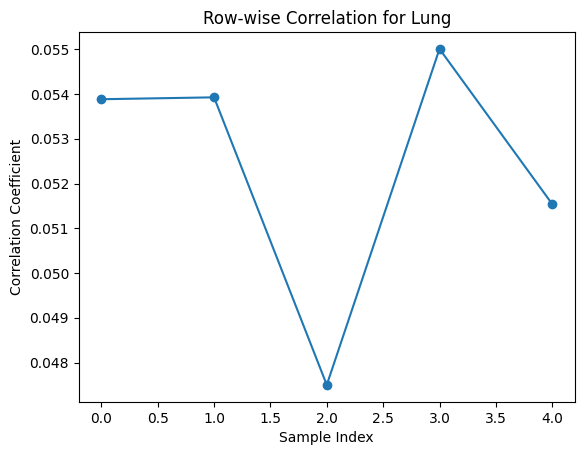

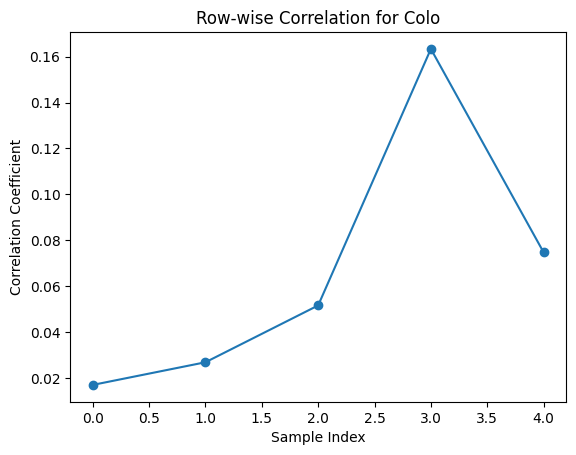

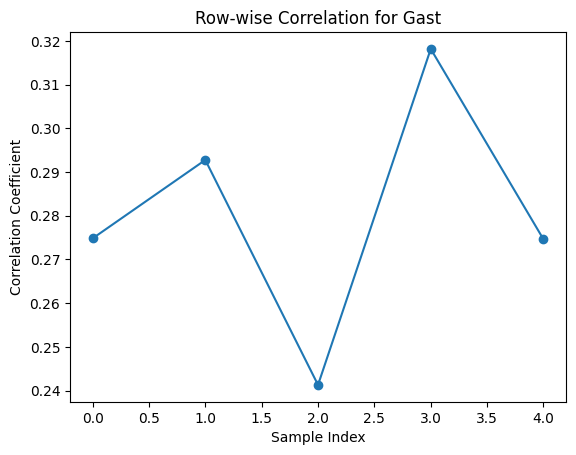

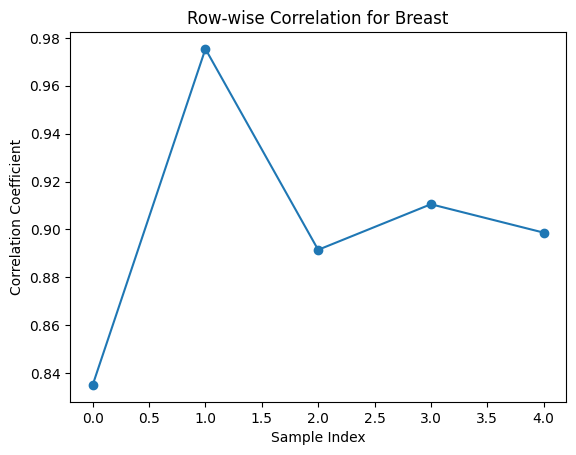

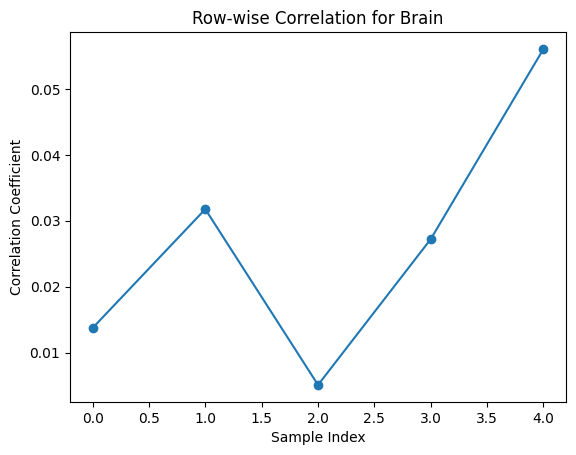

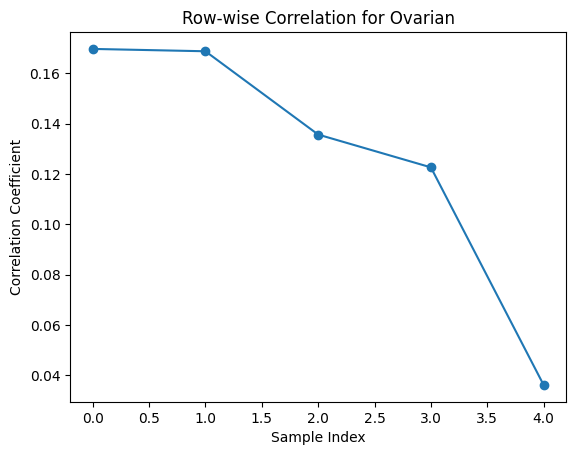

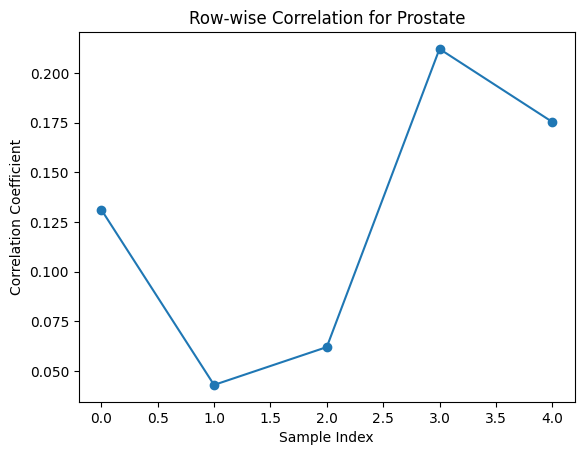

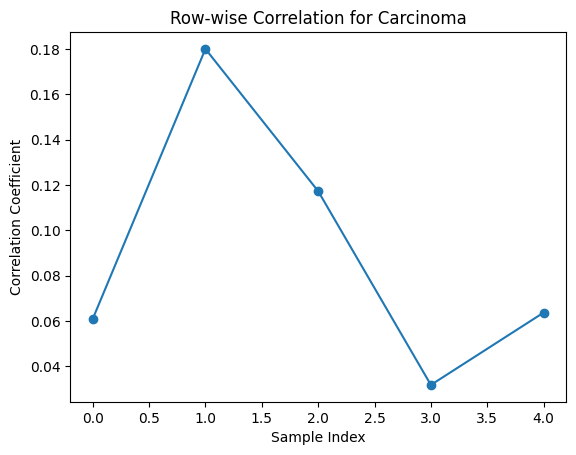

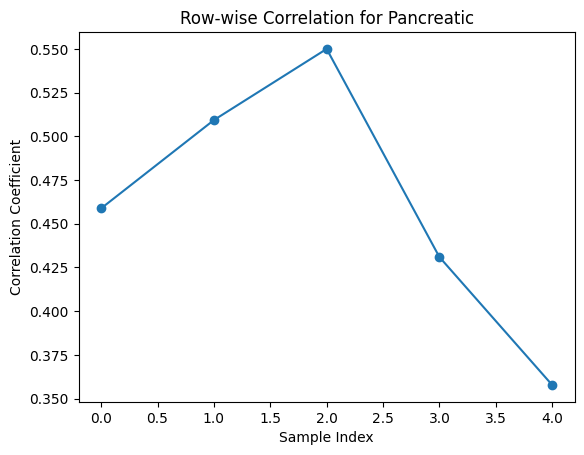

In [6]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
# List of datasets and their corresponding labels
datasets = [df_lung, df_colo, df_gast, df_breast, df_brain, df_ovarian, df_prostate, df_carcinoma, df_pancreatic]
labels_list = [df_lung_labels, df_colo_labels, df_gast_labels, df_breast_labels, labels_brain, labels_ovarian, labels_prostate, labels_carcinoma, labels_pancreatic]
dataset_names = ['Lung', 'Colo', 'Gast', 'Breast', 'Brain', 'Ovarian', 'Prostate','Carcinoma', 'Pancreatic']

# Loop through each dataset and plot the row-wise correlation
for idx, (df, labels) in enumerate(zip(datasets, labels_list)):
    processed_df = process(df, labels)

    # Align the datasets row-wise (transpose if needed for row-wise operations)
    lung_rows = processed_df.to_numpy()
    test_rows = df_test.to_numpy()

    # Ensure the row dimensions match
    min_samples = min(len(lung_rows), len(test_rows))
    lung_rows = lung_rows[:min_samples]
    test_rows = test_rows[:min_samples]

    # Compute row-wise correlations
    row_correlations = [
        pearsonr(lung_rows[i], test_rows[i])[0] for i in range(min_samples)
    ]

    # Plotting the row-wise correlation for each dataset
    plt.figure(idx)
    plt.plot(row_correlations, marker='o')
    plt.title(f"Row-wise Correlation for {dataset_names[idx]}")
    plt.xlabel("Sample Index")
    plt.ylabel("Correlation Coefficient")
    plt.show()

In [7]:
#outliers removal and normalization
def normalize_entire_dataset(df_train, df_test):
    # Combine train and test DataFrames
    combined_df = pd.concat([df_train, df_test], ignore_index=True)
    
    # Flatten the entire dataset into a single array and normalize
    min_val = combined_df.min().min()  # Minimum value across all elements
    max_val = combined_df.max().max()  # Maximum value across all elements
    
    # Avoid division by zero if all values are constant
    if max_val != min_val:
        combined_df = (combined_df - min_val) / (max_val - min_val)
    
    # Separate the DataFrames back into train and test
    df_train_normalized = combined_df.iloc[:len(df_train), :].reset_index(drop=True)
    df_test_normalized = combined_df.iloc[len(df_train):, :].reset_index(drop=True)
    
    return df_train_normalized, df_test_normalized



# df_train = normalize_dataset(df_train)
# df_test = normalize_dataset(df_test)
df_train, df_test = normalize_entire_dataset(df_train, df_test)


In [8]:
# Define NGS version as a variable
# folder_path = "E:/MedBank/head_model/head/work_dir/model_ready_folders/setolabo_samples_as_test/FD3"  # You can change this value as needed
folder_path = "E:/MedBank/head_model/NGS/data_shared_by_Takeshi-san/model_ready_folders/setolabo_samples_as_test/FD10"  # You can change this value as needed

# Paths for train and test feature vectors
file_path = f"{folder_path}/train/feature_vectors.csv"
df_train.to_csv(file_path, index=False, header=False)

file_path = f"{folder_path}/test/feature_vectors.csv"
df_test.to_csv(file_path, index=False, header=False)

##--------------------------------------------------------

# Paths for train and test labels
file_path = f"{folder_path}/train/labels.txt"
with open(file_path, 'w') as file:
    for label in labels_train:
        file.write(f"{label}\n")

file_path = f"{folder_path}/test/labels.txt"
with open(file_path, 'w') as file:
    for label in labels_test:
        file.write(f"{label}\n")

##--------------------------------------------------------

# Path for feature names
file_path = f"{folder_path}/feature_names.txt"
with open(file_path, 'w') as file:
    for label in features:
        file.write(f"{label}\n")